Hello!

Here I will give some syntax for forecasting.
Last project I did actually has a lot of things to forecast. So, to simplify all the process I made it to some functions that later I will break it down.

Please take a note that the functions I made here is only suitable with cross validation that I used, one step forecast cross validation.

Please import all the libraries below

In [27]:
#This library is for data wrangling
import pandas as pd
#This one for making array here. But in other projects this library will give you a lot of benefits
import numpy as np
#This one is the metrics we use in this project
#Actualy I use RMSE here, but because sklearn only have MSE. Then lets use square root
from sklearn.metrics import mean_squared_error
#This one is to remove warnings
#FYI, each warning is precious, only use this if you really need
import warnings
warnings.filterwarnings("ignore")

# Importing data

Lets import the data using pandas. We use index column 0, you will see it later.

In [28]:
df = pd.read_csv('airline_passengers.csv', index_col=0)

You can see it down here, that Month has become index in the data frame

In [29]:
df.head()

,Thousands of Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


The data frame contains 144 rows and have 1 column.

In [32]:
df.shape

(144, 1)

Before going further, first we need to know the data. Simplest way to know it is to plot it.
Lets use pandas built-in method, plot.

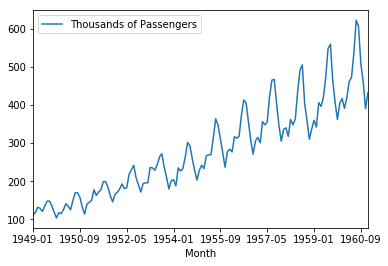

In [33]:
df.plot.line(y='Thousands of Passengers');

# Cross Validation - one-step forecasts

Before moving to the functions I use, lets learn more about cross validation in time series.
Generally cross validation is splitting data into two parts, train and test. But because time series data has special nature, we need to consider its order to split it. So, we have to use 'before' data as train, and 'after' data as test (this is my personal way to call it).

One-step forecast focuses on a single forecast horizon for each test set.

I attached a document in the same folder as this jupyter notebook file that you can read. It titled `Time Series Cross Validation`

Here we have 144 observations, and I will use 140 data as train and another 4 as test data.

# Forecasting

Basically, the steps I used in each functions are the same. I will try to explain it simply
1. In each functions, I will have `rmse = []` to store the rmse I got. This will help us in choosing the best model.
2. I will also have a list containing combinations of hyperparameters I use. It will be different in each method.
3. Some looping (`for blablabla` things) before `forcs = []` is the looping of hyperparameters I use.
4. `forcs = []` is used to store the forecast result in each step (related to cross validations I mention before).
5. `rmse.append(np.sqrt(mean_squared_error(train_data.iloc[train_number:, 0].tolist(), forcs)))` this line is to take the RMSE of each hyperparameters combination
6. `return (range(1,50)[rmse.index([min(rmse)])], min(rmse))` and then I will return just the best hyperparameters and the smallest RMSE
7. You will see some `try` and `except` things. Those are for handling error in the process. You can google it with keyword `exception in python`

All input format in each function are `(df,number of train data,number of test data)`.

## Baseline model : MA

Here I use MA as the baseline model.

Why we need baseline model? To know how far can our best model predict something, we need a comparison with a baseline model, which is the simplest and easiest method we use. So, if a complex model's performace not much better than the baseline's, then just use the easiest one.

MA is a methods that just averaging n observations before to forecast the next one observation.

For further informations, please google it with keyword "Simple Moving Average"

Hyperparameter that I need to tune here is the value of n (number of observations to average).

In [34]:
def MA(train_data, train_number, test_number):
    rmse = []
    for i in range(1, 50): #looping n
        forcs = []
        for roll in range(0, test_number):
            train = train_data.iloc[1:(train_number + roll), 0]
            forecast = train.iloc[(len(train) - i):].mean()
            forcs.append(forecast)
        rmse.append(np.sqrt(mean_squared_error(train_data.iloc[train_number:, 0].tolist(), forcs)))
    print('Best hyperparameter is ' + str(range(1,50)[rmse.index([min(rmse)])])+ ' with RMSE ' + str(min(rmse)))

Then you can use it here to forecast the data.

In [35]:
MA(df,140,4)

Best hyperparameter is 26 with RMSE 43.03458169767066


## Single Exponential Smoothing

In [36]:
from statsmodels.tsa.api import SimpleExpSmoothing

In single exponential smoothing, hyperparameter we need to tune is alpha (first order smoothing factor)

In [37]:
def SES(train_data, train_number, test_number):
    alpha = []
    rmse = []
    for i in np.arange(0, 1, 0.01): #looping alpha
        forcs = []
        for roll in range(0, test_number):
            train = train_data.iloc[1:(train_number + roll), 0]
            simpleexp = SimpleExpSmoothing(np.array(train))
            fit_simpleexp = simpleexp.fit(smoothing_level=i)
            forecast = fit_simpleexp.forecast()
            forcs.append(forecast[0])
        rmse.append(np.sqrt(mean_squared_error(train_data.iloc[train_number:, 0].tolist(), forcs)))
        alpha.append(i)
    print('Best hyperparameter is ' + str(alpha[rmse.index([min(rmse)])])+ ' with RMSE ' + str(min(rmse)))

In [38]:
SES(df,140,4)

Best hyperparameter is 0.07 with RMSE 44.425253945643554


## Double Exponential Smoothing

In [39]:
from statsmodels.tsa.api import Holt

In double exponential smoothing, hyperparameter we need to tune are alpha (first order smoothing factor) and beta (second order smoothing factor)

In [44]:
def DEF(train_data, train_number, test_number):
    alpha_beta = []
    rmse = []
    for alpha in np.arange(0.1, 1, 0.1): #looping on alpha
        for beta in np.arange(0, 1, 0.1): #looping on beta
            forcs = []
            for roll in range(0, test_number):
                train = train_data.iloc[1:(train_number + roll), 0]
                double_exp = Holt(np.array(train), exponential=True)
                fit_double_exp = double_exp.fit(smoothing_level=alpha, smoothing_slope=beta)
                forecast = fit_double_exp.forecast()
                forcs.append(forecast[0])
            rmse.append(np.sqrt(mean_squared_error(train_data.iloc[train_number:, 0].tolist(), forcs)))
            alpha_beta.append([alpha, beta])
    print('Best hyperparameter is ' + str(alpha_beta[rmse.index([min(rmse)])])+ ' with RMSE ' + str(min(rmse)))

In [45]:
DEF(df, 140,4)

Best hyperparameter is [0.9, 0.0] with RMSE 73.79346823046899


## Double Exponential with Dampening

In this kind of double exponential smoothing, hyperparameter we need to tune are alpha (first order smoothing factor), beta (second order smoothing factor), and damping factor. Dampening means reducing the size of the trend over future time steps down to a straight line (no trend).

https://machinelearningmastery.com/exponential-smoothing-for-time-series-forecasting-in-python/

You can check it here for future information.

In [70]:
def DEF_damping(train_data, train_number, test_number):
    alpha_beta_damp = []
    rmse = []
    for alpha in np.arange(0.1, 1, 0.1): #looping on alpha
        for beta in np.arange(0, 1, 0.1): #looping on beta
            for damp in np.arange(0.8,1,0.1): #looping on damping coefficient
                forcs = []
                for roll in range(0, test_number):
                    train = train_data.iloc[1:(train_number + roll), 0]
                    double_exp = Holt(np.array(train), exponential=True, damped=True)
                    fit_double_exp = double_exp.fit(smoothing_level=alpha, smoothing_slope=beta, damping_slope=damp)
                    forecast = fit_double_exp.forecast()
                    forcs.append(forecast[0])
                rmse.append(np.sqrt(mean_squared_error(train_data.iloc[train_number:, 0].tolist(), forcs)))
                alpha_beta_damp.append([alpha, beta, damp])
    print('Best hyperparameter is ' + str(alpha_beta_damp[rmse.index([min(rmse)])])+ ' with RMSE ' + str(min(rmse)))

In [71]:
DEF_damping(df,140,4)

Best hyperparameter is [0.1, 0.0, 0.8] with RMSE 48.26647990549607


## Holt Winter

In [49]:
from statsmodels.tsa.api import ExponentialSmoothing

In Holt Winter method, I just tune between additive and multiplicative methods. In the next improvement maybe we can tune first order, second order, and seasonal factor.

In [72]:
def holt_winter(train_data, train_number, test_number):
    trend_seasonal = []
    rmse = []
    trends = ['add', 'mul']
    seasonals = ['add', 'mul']
    for trend in trends :
        for seasonal in seasonals:
            forcs = []
            for roll in range(0, test_number):
                train = train_data.iloc[1:(train_number + roll), 0]
                holt_w = ExponentialSmoothing(np.array(train), trend=trend, seasonal=seasonal, seasonal_periods=4)
                fit_holt_w = holt_w.fit(use_boxcox=True)
                forecast = fit_holt_w.forecast()
                forcs.append(forecast[0])
            rmse.append(np.sqrt(mean_squared_error(train_data.iloc[train_number:, 0].tolist(), forcs)))
            trend_seasonal.append([trend, seasonal])
    print('Best hyperparameter is ' + str(trend_seasonal[rmse.index([min(rmse)])])+ ' with RMSE ' + str(min(rmse)))

In [73]:
holt_winter(df, 140,4)

Best hyperparameter is ['mul', 'add'] with RMSE 40.205102245547224


## ARIMA

In [74]:
from statsmodels.tsa.api import ARIMA

In ARIMA, I tune p,d,q as combinations of 0,1, and 2

In [75]:
def arima(train_data, train_number, test_number):
    order_ = []
    rmse = []
    for p in range(0,3) :
        for d in range(0,3):
            for q in range(0,3):
                try: 
                    forcs = []
                    for roll in range(0, test_number):
                        train = train_data.iloc[1:(train_number + roll), 0]
                        arima_mod = ARIMA(np.array(train), order=[p,d,q])
                        fit_arima = arima_mod.fit(use_boxcox=True)
                        forecast = fit_arima.forecast()
                        forcs.append(forecast[0])
                    rmse.append(np.sqrt(mean_squared_error(train_data.iloc[train_number:, 0].tolist(), forcs)))
                    order_.append([p,d,q])
                except:
                    pass
    print('Best hyperparameter is ' + str(order_[rmse.index([min(rmse)])])+ ' with RMSE ' + str(min(rmse)))

In [76]:
arima(df, 140,4)

Best hyperparameter is [2, 1, 1] with RMSE 40.66976181781795


## SARIMA

In [77]:
from statsmodels.tsa.api import SARIMAX
import itertools

SARIMA : tune the (p,d,q)(P,D,Q,m) with m=12. Because the data frame is monthly data, so it hopefully have 1 year seasonal pattern

In [78]:
def sarima(train_data, train_number, test_number):
    p = d = q = range(0, 2)
    m = [12]
    order_ = []
    rmse =[]
    pdq = list(itertools.product(p,d,q))
    pdq_seasonal = list(itertools.product(p,d,q,m))
    for pdq_i in pdq :
        for s_i in pdq_seasonal:
            try: 
                forcs = []
                for roll in range(0, test_number):
                    train = train_data.iloc[1:(train_number + roll), 0]
                    sarima_mod = SARIMAX(np.array(train), order=pdq_i, seasonal_order=s_i)
                    fit_sarima = sarima_mod.fit(use_boxcox=True)
                    forecast = fit_sarima.forecast()
                    forcs.append(forecast[0])
                rmse.append(np.sqrt(mean_squared_error(train_data.iloc[train_number:, 0].tolist(), forcs)))
                order_.append([pdq_i, s_i])
            except:
                pass
    print('Best hyperparameter is ' + str(order_[rmse.index([min(rmse)])])+ ' with RMSE ' + str(min(rmse)))

In [79]:
sarima(df,140,4)

Best hyperparameter is [(1, 0, 1), (1, 1, 1, 12)] with RMSE 11.970535709947109


# Comparing all methods

Let's make it in one line.

In [80]:
def compare(train_data, train_number, test_number):
    print('Hasil MA')
    try :
        MA(train_data, train_number, test_number)
    except:
        pass
    print('Hasil single exponential smoothing')
    try:
        SES(train_data, train_number, test_number)
    except:
        pass
    print('Hasil Double Exponential Smoothing')
    try :
        DEF(train_data, train_number, test_number)
    except :
        pass
    print('Hasil Double Exponential with Damping')
    try :
        DEF_damping(train_data, train_number, test_number)
    except:
        pass
    print('Hasil Holt-Winter')
    try :
        holt_winter(train_data, train_number, test_number)
    except:
        pass
    print('Hasil ARIMA')
    try:
        arima(train_data, train_number, test_number)
    except:
        pass
    print('Hasil SARIMA')
    try:
        sarima(train_data, train_number, test_number)
    except:
        pass

In [81]:
compare(df,140,4)

Hasil MA
Best hyperparameter is 26 with RMSE 43.03458169767066
Hasil single exponential smoothing
Best hyperparameter is 0.07 with RMSE 44.425253945643554
Hasil Double Exponential Smoothing
Best hyperparameter is [0.9, 0.0] with RMSE 73.79346823046899
Hasil Double Exponential with Damping
Best hyperparameter is [0.1, 0.0, 0.8] with RMSE 48.26647990549607
Hasil Holt-Winter
Best hyperparameter is ['mul', 'add'] with RMSE 40.205102245547224
Hasil ARIMA
Best hyperparameter is [2, 1, 1] with RMSE 40.66976181781795
Hasil SARIMA
Best hyperparameter is [(1, 0, 1), (1, 1, 1, 12)] with RMSE 11.970535709947109
